In [3]:
#Celda 1 --- Limpieza de datos

import pandas as pd
import numpy as np

POBLACION_2020 = {
    # CÓDIGO_INEGI: (NOMBRE_ESTADO, POBLACIÓN_TOTAL_2020)
    1: ('Aguascalientes', 1425607),
    2: ('Baja California', 3769020),
    3: ('Baja California Sur', 798447),
    4: ('Campeche', 928363),
    5: ('Coahuila de Zaragoza', 3146771),
    6: ('Colima', 731391),
    7: ('Chiapas', 5543828),
    8: ('Chihuahua', 3741869),
    9: ('Ciudad de México', 9209944),
    10: ('Durango', 1832650),
    11: ('Guanajuato', 6181650),
    12: ('Guerrero', 3574677),
    13: ('Hidalgo', 3082841),
    14: ('Jalisco', 8348151),
    15: ('México', 16992418),
    16: ('Michoacán de Ocampo', 4748846),
    17: ('Morelos', 1971520),
    18: ('Nayarit', 1235456),
    19: ('Nuevo León', 5784442),
    20: ('Oaxaca', 4132148),
    21: ('Puebla', 6583278),
    22: ('Querétaro', 2368467),
    23: ('Quintana Roo', 1857985),
    24: ('San Luis Potosí', 2822255),
    25: ('Sinaloa', 3177239),
    26: ('Sonora', 2955318),
    27: ('Tabasco', 2403027),
    28: ('Tamaulipas', 3527735),
    29: ('Tlaxcala', 1342977),
    30: ('Veracruz de Ignacio de la Llave', 8530279),
    31: ('Yucatán', 2320898),
    32: ('Zacatecas', 1622086)
}

# Cargar el archivo, asegurando la separación correcta (comas o tabs, dependiendo del archivo)
# Asumo que 'Datos abiertos dengue_311220.csv' usa comas. Si es con tabs, cambia 'sep=',' por 'sep='\t''.
try:
    df = pd.read_csv('../data/Datos abiertos dengue_311220.csv') 
except FileNotFoundError:
    raise FileNotFoundError("Asegúrate de que 'Datos abiertos dengue_311220.csv' esté en la carpeta 'data' o proporciona la ruta correcta.")
    
# 1. Limpieza de Fechas: Convertir a formato de fecha
df['FECHA_SIGN_SINTOMAS'] = pd.to_datetime(df['FECHA_SIGN_SINTOMAS'], errors='coerce')
df.dropna(subset=['FECHA_SIGN_SINTOMAS'], inplace=True) # Eliminar filas con fechas nulas

# 2. Filtrado CRÍTICO: Solo casos confirmados (ESTATUS_CASO = 1)
# El resto son casos descartados o probables, no deben usarse como Y.
df_confirmados = df[df['ESTATUS_CASO'] == 1].copy()

# 3. Mapeo de Población y Estado
# Creamos un DataFrame a partir de nuestro diccionario de población
df_poblacion = pd.DataFrame(POBLACION_2020).T
df_poblacion.columns = ['NOMBRE_ESTADO', 'POBLACION']
df_poblacion.index.name = 'ENTIDAD_RES'

# Unir el nombre del estado y la población al DataFrame de casos
df_confirmados = df_confirmados.merge(df_poblacion, on='ENTIDAD_RES', how='left')

# ⚠️ Limpieza de Nulos (Nulls): Filas que no coincidan con un código estatal (error)
print(f"Casos sin Población (Códigos de Estado Inválidos/Faltantes): {df_confirmados['POBLACION'].isnull().sum()}")
df_confirmados.dropna(subset=['POBLACION'], inplace=True) # Eliminar estos casos, son errores de captura.

# 4. Agregación: Contar casos por semana y entidad
df_ts = (
    df_confirmados.groupby(['ENTIDAD_RES', 'NOMBRE_ESTADO', 'POBLACION'])
    .resample('W', on='FECHA_SIGN_SINTOMAS')
    .size()
    .reset_index(name='CASOS_CONFIRMADOS')
)

# 5. Calcular la Tasa de Incidencia (Tu métrica profesional)
# TI = (Casos / Población) * 100,000
df_ts['TASA_INCIDENCIA'] = (df_ts['CASOS_CONFIRMADOS'] / df_ts['POBLACION']) * 100000

# Quitamos la columna de Población, ya que está "embebida" en la Tasa de Incidencia
df_ts.drop(columns=['POBLACION', 'ENTIDAD_RES'], inplace=True)
df_ts.rename(columns={'FECHA_SIGN_SINTOMAS': 'SEMANA_EPIDEMIOLOGICA'}, inplace=True)

print("--- DataFrame Final de Series de Tiempo (Primeras 5 Filas) ---")
print(df_ts.head())

# 6. Lag Features (Memoria del Virus)
# Usaremos 1, 4 y 12 semanas para capturar el ciclo de transmisión y la estacionalidad mensual/trimestral.
lags = [1, 4, 12]

for lag in lags:
    # Agrupamos por estado y creamos la columna rezagada
    df_ts[f'TI_LAG_{lag}W'] = df_ts.groupby('NOMBRE_ESTADO')['TASA_INCIDENCIA'].shift(lag)
    df_ts[f'CASOS_LAG_{lag}W'] = df_ts.groupby('NOMBRE_ESTADO')['CASOS_CONFIRMADOS'].shift(lag)

# ⚠️ Limpieza de Nulos (Nulls): Los primeros 12 valores por estado ahora son Null
# ya que no tienen semanas anteriores. Se deben eliminar para el entrenamiento.
df_ts.dropna(inplace=True)
print(f"\nFilas restantes después de crear Lag Features y eliminar Nulos: {len(df_ts)}")

# 7. Features de Tiempo (Estacionalidad)
# El Random Forest necesita la estacionalidad como una variable numérica
df_ts['SEMANA_DEL_ANIO'] = df_ts['SEMANA_EPIDEMIOLOGICA'].dt.isocalendar().week.astype(int)
df_ts['MES'] = df_ts['SEMANA_EPIDEMIOLOGICA'].dt.month

# 8. Definir Umbral de Riesgo (Percentil 75)
# El riesgo alto es cuando la Tasa de Incidencia excede el 75% de los valores históricos
umbral_riesgo = df_ts['TASA_INCIDENCIA'].quantile(0.75)

print(f"\nUmbral de Riesgo (Percentil 75) de Tasa de Incidencia: {umbral_riesgo:.2f}")

# 9. Crear la Variable Objetivo Binaria (Y)
df_ts['RIESGO_BROTE'] = np.where(df_ts['TASA_INCIDENCIA'] > umbral_riesgo, 1, 0)



Casos sin Población (Códigos de Estado Inválidos/Faltantes): 8
--- DataFrame Final de Series de Tiempo (Primeras 5 Filas) ---
    NOMBRE_ESTADO SEMANA_EPIDEMIOLOGICA  CASOS_CONFIRMADOS  TASA_INCIDENCIA
0  Aguascalientes            2020-07-19                  1         0.070146
1  Aguascalientes            2020-07-26                  0         0.000000
2  Aguascalientes            2020-08-02                  0         0.000000
3  Aguascalientes            2020-08-09                  0         0.000000
4  Aguascalientes            2020-08-16                  0         0.000000

Filas restantes después de crear Lag Features y eliminar Nulos: 1121

Umbral de Riesgo (Percentil 75) de Tasa de Incidencia: 1.62


C:\Users\es982\AppData\Local\Temp\ipykernel_23948\1408137709.py:74: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .size()


In [4]:
# ----------------------------------------------------
# CELDA 2: Preparación del Conjunto de Datos y División
# ----------------------------------------------------

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import joblib 
import matplotlib.pyplot as plt
import seaborn as sns

# Creamos el codificador (LabelEncoder) para que el modelo entienda los estados.
le = LabelEncoder()
df_ts['ENTIDAD_CODED'] = le.fit_transform(df_ts['NOMBRE_ESTADO'])

# Definir Features (X) y Target (Y)
features = [
    'TI_LAG_1W', 
    'TI_LAG_4W', 
    'CASOS_LAG_1W', 
    'CASOS_LAG_4W', 
    'SEMANA_DEL_ANIO', 
    'MES',
    'ENTIDAD_CODED' # El factor geográfico codificado
]

X = df_ts[features]
Y = df_ts['RIESGO_BROTE'] # 1=Riesgo Alto, 0=Riesgo Bajo

# División de Datos: 70% Entrenamiento, 30% Prueba
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, 
    test_size=0.3, 
    random_state=42, 
    stratify=Y
)

print(f"Set de entrenamiento (X_train): {X_train.shape}")

Set de entrenamiento (X_train): (784, 7)


In [5]:
# ----------------------------------------------------
# CELDA 3: Entrenamiento y Métricas
# ----------------------------------------------------

from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report

# 1. Definición y Entrenamiento del Modelo
rf_classifier = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    class_weight='balanced', 
    max_depth=10 
)

print("Entrenando Random Forest Classifier...")
rf_classifier.fit(X_train, Y_train)

# 2. Predicciones
Y_pred = rf_classifier.predict(X_test)
Y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1] # Probabilidad de la clase 1 (Riesgo Alto)

# 3. AUC-ROC Score (Métrica principal)
auc_score = roc_auc_score(Y_test, Y_pred_proba)
print(f"\n✅ AUC-ROC Score en Set de Prueba: {auc_score:.4f}")

# 4. Reporte de Clasificación (Mira el Recall de la clase 1)
print("\n--- Reporte de Clasificación Detallado ---")
print(classification_report(Y_test, Y_pred))

Entrenando Random Forest Classifier...

✅ AUC-ROC Score en Set de Prueba: 0.9778

--- Reporte de Clasificación Detallado ---
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       253
           1       0.84      0.88      0.86        84

    accuracy                           0.93       337
   macro avg       0.90      0.91      0.91       337
weighted avg       0.93      0.93      0.93       337



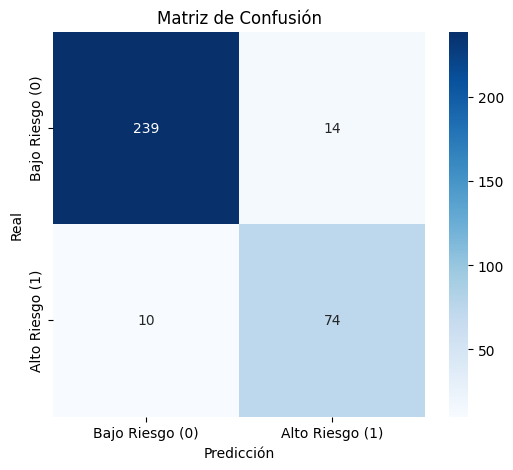

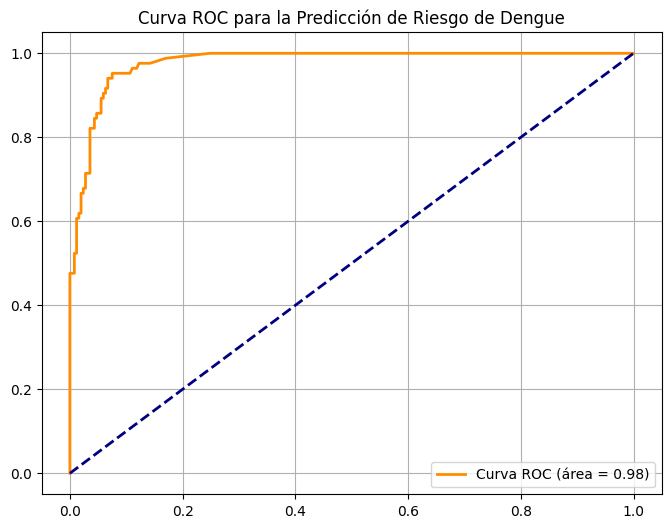

In [6]:
# ----------------------------------------------------
# CELDA 4: Visualización (Curva ROC y Matriz)
# ----------------------------------------------------

from sklearn.metrics import roc_curve

# 1. Matriz de Confusión (para ver Falsos Negativos - ¡Peligro!)
cm = confusion_matrix(Y_test, Y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Bajo Riesgo (0)', 'Alto Riesgo (1)'], 
            yticklabels=['Bajo Riesgo (0)', 'Alto Riesgo (1)'])
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.title('Matriz de Confusión')
plt.show()

# 2. Curva ROC (Gráfica estándar en ML para clasificadores)
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (área = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Curva ROC para la Predicción de Riesgo de Dengue')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [8]:
# ----------------------------------------------------
# CELDA 5: Guardar Artefactos (¡Conexión con Flask!)
# ----------------------------------------------------

# Asegúrate de que la carpeta 'backend/' exista en la raíz de tu proyecto.
try:
    # 1. Guardar el modelo entrenado (el "cerebro" de la predicción)
    joblib.dump(rf_classifier, '../backend/model.pkl')
    
    # 2. Guardar el LabelEncoder (Necesario para que Flask sepa cómo codificar el estado de entrada)
    joblib.dump(le, '../backend/label_encoder.pkl') 

    print("\nModelos guardados exitosamente en la carpeta 'backend/'.")

except FileNotFoundError:
    print("¡ERROR! Asegúrate de haber creado la carpeta 'backend/' en la raíz de tu proyecto.")


Modelos guardados exitosamente en la carpeta 'backend/'.
